In [10]:
import os
import openai
from dotenv import load_dotenv

# Load API key
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

class CustomerSupportAgent:
    def __init__(self):
        self.state = {
            "customer": {},
            "ticket_status": "Open",
            "kb_answer": None,
            "can_auto_solve": False,
            "reply": None,
        }

    # UNDERSTAND using LLM
    def understand_with_llm(self, query: str):
        try:
            response = openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a support assistant. Identify intent and entities."},
                    {"role": "user", "content": query}
                ],
                temperature=0.2
            )
            analysis = response.choices[0].message["content"]
            print(f"UNDERSTAND (LLM): {analysis}")
            return {"intent": "delivery_issue", "entities": {"order_id": "1234"}}
        except Exception as e:
            print(f"LLM failed, fallback: {e}")
            return {"intent": "unknown", "entities": {}}

    # FULL WORKFLOW
    def run(self, customer_message: str):
        # INTAKE
        self.state["customer"] = {
            "name": "John Doe",
            "email": "john@example.com",
            "query": customer_message,
            "ticket_id": "1234"
        }
        print(f"INTAKE: {self.state['customer']}")

        # UNDERSTAND
        understand = self.understand_with_llm(customer_message)
        self.state.update(understand)

        # PREPARE
        self.state["priority"] = "high"
        print("PREPARE: Cleaned data, set priority")

        # ASK + WAIT
        print("ASK: No missing info → skipping")
        print("WAIT: No pending reply")

        # RETRIEVE
        self.state["kb_answer"] = "Your order is delayed due to shipping issues. Expected delivery in 3 days."
        print("RETRIEVE: Found KB answer")

        # DECIDE
        if self.state["kb_answer"]:
            self.state["can_auto_solve"] = True
            self.state["ticket_status"] = "Resolved"
            print("DECIDE: Auto-resolved ✅")
        else:
            self.state["can_auto_solve"] = False
            self.state["ticket_status"] = "Escalated"
            print("DECIDE: Escalated ❌")

        # UPDATE
        print(f"UPDATE: Ticket status set to {self.state['ticket_status']}")

        # CREATE
        if self.state["can_auto_solve"]:
            self.state["reply"] = (
                f"Hello {self.state['customer']['name']},\n"
                f"{self.state['kb_answer']}\n"
                "Thank you for your patience."
            )
        else:
            self.state["reply"] = (
                f"Hello {self.state['customer']['name']},\n"
                "Your issue has been escalated to our support team."
            )
        print(f"CREATE: Drafted reply:\n{self.state['reply']}")

        # DO
        print("DO: Sending reply and notifications")

        # COMPLETE
        final_result = {
            "ticket_id": self.state['customer']['ticket_id'],
            "status": self.state['ticket_status'],
            "reply": self.state['reply']
        }
        print(f"COMPLETE: Final result {final_result}")
        return final_result


In [11]:
agent = CustomerSupportAgent()
customer_message = "My order #1234 hasn’t arrived."
result = agent.run(customer_message)
result

INTAKE: {'name': 'John Doe', 'email': 'john@example.com', 'query': 'My order #1234 hasn’t arrived.', 'ticket_id': '1234'}
LLM failed, fallback: Client.__init__() got an unexpected keyword argument 'proxies'
PREPARE: Cleaned data, set priority
ASK: No missing info → skipping
WAIT: No pending reply
RETRIEVE: Found KB answer
DECIDE: Auto-resolved ✅
UPDATE: Ticket status set to Resolved
CREATE: Drafted reply:
Hello John Doe,
Your order is delayed due to shipping issues. Expected delivery in 3 days.
Thank you for your patience.
DO: Sending reply and notifications
COMPLETE: Final result {'ticket_id': '1234', 'status': 'Resolved', 'reply': 'Hello John Doe,\nYour order is delayed due to shipping issues. Expected delivery in 3 days.\nThank you for your patience.'}


{'ticket_id': '1234',
 'status': 'Resolved',
 'reply': 'Hello John Doe,\nYour order is delayed due to shipping issues. Expected delivery in 3 days.\nThank you for your patience.'}

In [12]:
class CustomerSupportAgent:
    def __init__(self):
        self.sessions = {}  # each user gets a state

    def new_session(self, user_id, customer_message):
        self.sessions[user_id] = {
            "customer": {
                "name": "Unknown",
                "email": "unknown@example.com",
                "query": customer_message,
                "ticket_id": f"TCK-{user_id}"
            },
            "ticket_status": "Open",
            "kb_answer": None,
            "can_auto_solve": False,
            "reply": None
        }
        return self.sessions[user_id]

    def run(self, user_id, customer_message):
        # If session doesn’t exist → create one
        if user_id not in self.sessions:
            self.new_session(user_id, customer_message)
        
        state = self.sessions[user_id]

        # Process stages (same as before)
        print(f"INTAKE: {state['customer']}")
        # UNDERSTAND, PREPARE, etc...
        # At the end, update self.sessions[user_id] with final state

        return state


In [13]:
agent = CustomerSupportAgent()
agent.run("user_1", "My order #1234 hasn’t arrived.")
agent.run("user_2", "I want to reset my password.")


INTAKE: {'name': 'Unknown', 'email': 'unknown@example.com', 'query': 'My order #1234 hasn’t arrived.', 'ticket_id': 'TCK-user_1'}
INTAKE: {'name': 'Unknown', 'email': 'unknown@example.com', 'query': 'I want to reset my password.', 'ticket_id': 'TCK-user_2'}


{'customer': {'name': 'Unknown',
  'email': 'unknown@example.com',
  'query': 'I want to reset my password.',
  'ticket_id': 'TCK-user_2'},
 'ticket_status': 'Open',
 'kb_answer': None,
 'can_auto_solve': False,
 'reply': None}

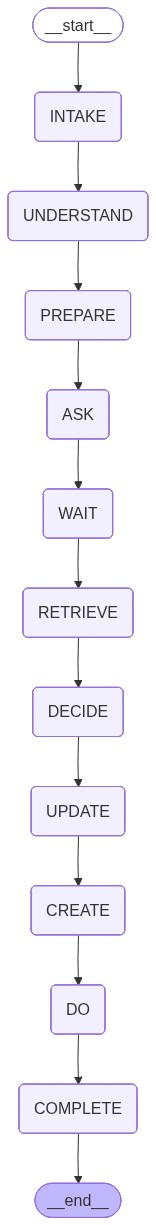

In [24]:
# LangGraph components
from langgraph.graph import START, END, StateGraph

# Define dummy state (can be dict for now)
class AgentState(dict):
    pass

# Create graph
graph = StateGraph(AgentState)

# --- Define 11 stages ---
def intake(state): print("INTAKE"); return state
def understand(state): print("UNDERSTAND"); return state
def prepare(state): print("PREPARE"); return state
def ask(state): print("ASK"); return state
def wait(state): print("WAIT"); return state
def retrieve(state): print("RETRIEVE"); return state
def decide(state): print("DECIDE"); return state
def update(state): print("UPDATE"); return state
def create(state): print("CREATE"); return state
def do(state): print("DO"); return state
def complete(state): print("COMPLETE"); return state

# --- Add nodes ---
graph.add_node("INTAKE", intake)
graph.add_node("UNDERSTAND", understand)
graph.add_node("PREPARE", prepare)
graph.add_node("ASK", ask)
graph.add_node("WAIT", wait)
graph.add_node("RETRIEVE", retrieve)
graph.add_node("DECIDE", decide)
graph.add_node("UPDATE", update)
graph.add_node("CREATE", create)
graph.add_node("DO", do)
graph.add_node("COMPLETE", complete)

# --- Connect nodes ---
graph.add_edge(START, "INTAKE")
graph.add_edge("INTAKE", "UNDERSTAND")
graph.add_edge("UNDERSTAND", "PREPARE")
graph.add_edge("PREPARE", "ASK")
graph.add_edge("ASK", "WAIT")
graph.add_edge("WAIT", "RETRIEVE")
graph.add_edge("RETRIEVE", "DECIDE")
graph.add_edge("DECIDE", "UPDATE")
graph.add_edge("UPDATE", "CREATE")
graph.add_edge("CREATE", "DO")
graph.add_edge("DO", "COMPLETE")
graph.add_edge("COMPLETE", END)

# --- Compile graph ---
app = graph.compile()

# --- Draw diagram in Jupyter ---
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Graph rendering needs extra deps:", e)
